# Bias in Non-Differentiable Resampling

The default implementation of PFs in cuthbert is currently non-differentiable, in the sense of providing biased score estimates when using automatic differentiation. Here, we illustrate this bias and that DPF ameliorates it on a linear-Gaussian system (where we can obtain analytical MLL/score estimates via the particle filter).

This is partially based on the [PFJax gradient comparisons](https://pfjax.readthedocs.io/en/latest/notebooks/gradient_comparisons.html).

In [1]:
import jax
import jax.numpy as jnp
from jax import random

import matplotlib.pyplot as plt

from cuthbert import filter as run_filter
from cuthbert.gaussian import kalman
from cuthbert.smc import particle_filter as pf
from cuthbertlib.stats.multivariate_normal import logpdf

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update(
    {
        "figure.dpi": 120,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "legend.frameon": False,
    }
)

The model that we simulate from is linear-Gaussian:
$$
\begin{align*}
 x_t &= x_{t-1} + \epsilon_t, \\
 y_t &= x_t + \eta_t,
\end{align*}
$$
where $x_0 \sim \mathcal{N}(m_0, P_0)$, $\epsilon_t \sim \mathcal{N}(0, q^2)$, and $\eta_t \sim \mathcal{N}(0, r^2)$. 

The model is thus parameterized by $(\log q, \log r)$.

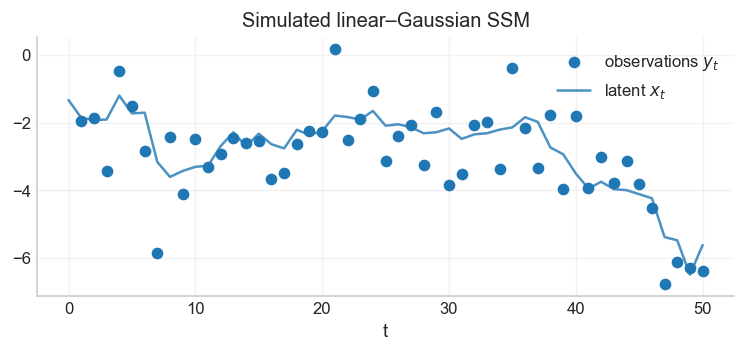

In [2]:
def simulate_data(key, *, T, theta_true, m0, chol_P0):
    log_q, log_r = theta_true
    q = jnp.exp(log_q)
    r = jnp.exp(log_r)

    key, kx0 = random.split(key)
    x0 = m0 + chol_P0 @ random.normal(kx0, (1,))

    def step(x_prev, k):
        kx, ky = random.split(k)
        x = x_prev + q * random.normal(kx, (1,))
        y = x + r * random.normal(ky, (1,))
        return x, (x, y)

    keys = random.split(key, T)
    _, (xs, ys) = jax.lax.scan(step, x0, keys)
    return jnp.concatenate([x0[None, :], xs], axis=0), ys


T = 50
m0 = jnp.array([0.0])
chol_P0 = jnp.array([[1.0]])

theta_true = jnp.array([jnp.log(0.4), jnp.log(0.8)])  # (log_q, log_r)

key = random.PRNGKey(0)
key, kdata = random.split(key)
xs, ys = simulate_data(kdata, T=T, theta_true=theta_true, m0=m0, chol_P0=chol_P0)

fig, ax = plt.subplots(figsize=(7.5, 2.8))
ax.scatter(jnp.arange(1, T + 1), ys[:, 0], label="observations $y_t$")
ax.plot(jnp.arange(0, T + 1), xs[:, 0], lw=1.5, alpha=0.8, label="latent $x_t$")
ax.set(title="Simulated linear–Gaussian SSM", xlabel="t")
ax.legend(loc="upper right")
plt.show()

We next set up utilities to examine the MLL of the Kalman filter, and bootstrap PF with and without differentiable resampling.

In [3]:
def kalman_mll(theta, ys, *, m0, chol_P0):
    """Exact log p(y_{1:T} | theta) via Kalman filter."""
    log_q, log_r = theta
    q = jnp.exp(log_q)
    r = jnp.exp(log_r)

    F = jnp.array([[1.0]])
    c = jnp.array([0.0])
    chol_Q = jnp.array([[q]])

    H = jnp.array([[1.0]])
    d = jnp.array([0.0])
    chol_R = jnp.array([[r]])

    def get_init_params(_mi):
        return m0, chol_P0

    def get_dynamics_params(_mi):
        return F, c, chol_Q

    def get_observation_params(mi):
        idx = mi - 1
        y = ys[idx]
        return H, d, chol_R, y

    kf = kalman.build_filter(get_init_params, get_dynamics_params, get_observation_params)
    model_inputs = jnp.arange(ys.shape[0] + 1)
    states = run_filter(kf, model_inputs, parallel=False)
    return states.log_normalizing_constant[-1]


kalman_grad = jax.grad(kalman_mll)

In [ ]:
from cuthbertlib.resampling import systematic
from cuthbertlib.resampling import adaptive
from cuthbertlib.resampling import stop_gradient

def pf_mll(
    theta,
    ys,
    *,
    key,
    n_particles,
    ess_threshold,
    m0,
    chol_P0,
    differentiable_resampling: bool,
):
    """Bootstrap PF estimate of log p(y_{1:T} | theta)."""
    log_q, log_r = theta
    q = jnp.exp(log_q)
    r = jnp.exp(log_r)

    H = jnp.array([[1.0]])
    d = jnp.array([0.0])
    chol_R = jnp.array([[r]])

    def init_sample(k, _mi):
        return m0 + (chol_P0 @ random.normal(k, (1,)))

    def propagate_sample(k, x_prev, _mi):
        return x_prev + q * random.normal(k, (1,))

    def log_potential(_x_prev, x, mi):
        idx = mi - 1
        return logpdf(H @ x + d, ys[idx], chol_R, nan_support=False)

    resampling_fn = (
        stop_gradient.stop_gradient_decorator(systematic.resampling)
        if differentiable_resampling
        else systematic.resampling
    )
    # In either case, do adaptive resampling
    resampling_fn = adaptive.ess_decorator(resampling_fn, ess_threshold)

    filt = pf.build_filter(
        init_sample=init_sample,
        propagate_sample=propagate_sample,
        log_potential=log_potential,
        n_filter_particles=n_particles,
        resampling_fn=resampling_fn,
    )

    model_inputs = jnp.arange(ys.shape[0] + 1)
    states = run_filter(filt, model_inputs, parallel=False, key=key)
    return states.log_normalizing_constant[-1]


pf_grad = jax.grad(lambda th, ys, **kw: pf_mll(th, ys, **kw))

# quick eval at theta_true (one random seed)
N_PF = 3_000
ess_threshold = 0.7

In [5]:
methods = {
    "Kalman (exact)": {"kind": "exact", "color": "black", "lw": 2.5, "alpha": 1.0},
    "PF (standard)": {"kind": "pf", "diff": False, "color": "tab:blue", "lw": 1.8, "alpha": 0.9},
    "PF (diff-resampling)": {
        "kind": "pf",
        "diff": True,
        "color": "tab:orange",
        "lw": 1.8,
        "alpha": 0.9,
    },
}

n_pts = 41
log_q_grid = jnp.linspace(float(theta_true[0]) - 1.2, float(theta_true[0]) + 1.2, n_pts)
log_r_grid = jnp.linspace(float(theta_true[1]) - 1.2, float(theta_true[1]) + 1.2, n_pts)

theta_grid_q = jnp.stack(
    [log_q_grid, jnp.full_like(log_q_grid, float(theta_true[1]))], axis=1
)
theta_grid_r = jnp.stack(
    [jnp.full_like(log_r_grid, float(theta_true[0])), log_r_grid], axis=1
)

key, k_pf_slice = random.split(key)


def eval_method_on_grid(method, grid):
    if method["kind"] == "exact":
        mll = jnp.array([kalman_mll(th, ys, m0=m0, chol_P0=chol_P0) for th in grid])
        grad = jnp.array([kalman_grad(th, ys, m0=m0, chol_P0=chol_P0) for th in grid])
        return mll, grad

    if method["kind"] == "pf":
        mll = jnp.array(
            [
                pf_mll(
                    th,
                    ys,
                    key=k_pf_slice,
                    n_particles=N_PF,
                    ess_threshold=ess_threshold,
                    m0=m0,
                    chol_P0=chol_P0,
                    differentiable_resampling=method["diff"],
                )
                for th in grid
            ]
        )
        grad = jnp.array(
            [
                pf_grad(
                    th,
                    ys,
                    key=k_pf_slice,
                    n_particles=N_PF,
                    ess_threshold=ess_threshold,
                    m0=m0,
                    chol_P0=chol_P0,
                    differentiable_resampling=method["diff"],
                )
                for th in grid
            ]
        )
        return mll, grad

    raise ValueError(f"Unknown kind: {method['kind']}")


results_q = {}
results_r = {}
for name, m in methods.items():
    results_q[name] = eval_method_on_grid(m, theta_grid_q)
    results_r[name] = eval_method_on_grid(m, theta_grid_r)

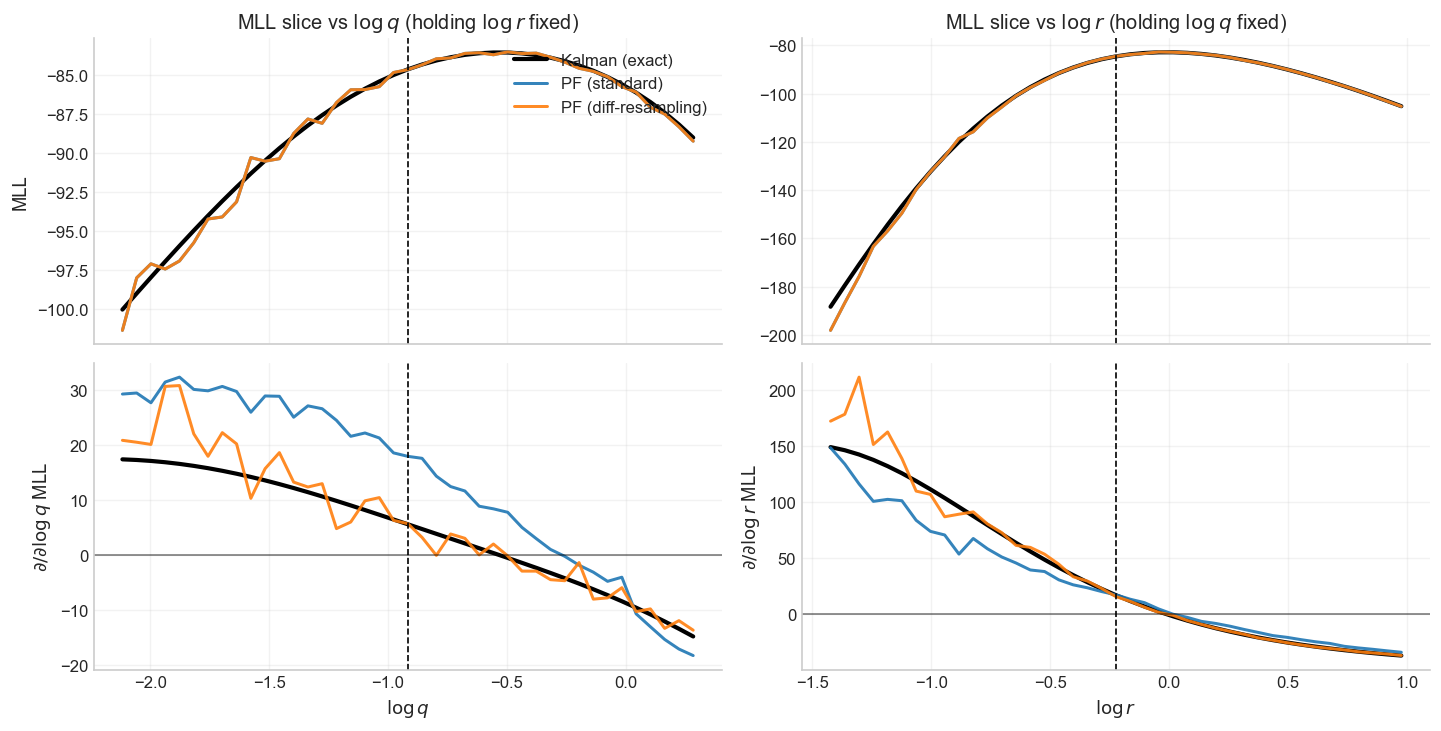

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6.2), sharex="col")

# MLL vs log_q
ax = axes[0, 0]
for name, m in methods.items():
    mll, _g = results_q[name]
    ax.plot(log_q_grid, mll, label=name, color=m["color"], lw=m["lw"], alpha=m["alpha"])
ax.axvline(theta_true[0], color="black", ls="--", lw=1)
ax.set(title=r"MLL slice vs $\log q$ (holding $\log r$ fixed)", ylabel="MLL")

# d/d log_q vs log_q
ax = axes[1, 0]
for name, m in methods.items():
    _mll, g = results_q[name]
    ax.plot(
        log_q_grid, g[:, 0], label=name, color=m["color"], lw=m["lw"], alpha=m["alpha"]
    )
ax.axhline(0.0, color="black", lw=1, alpha=0.5)
ax.axvline(theta_true[0], color="black", ls="--", lw=1)
ax.set(xlabel=r"$\log q$", ylabel=r"$\partial/\partial \log q$ MLL")

# MLL vs log_r
ax = axes[0, 1]
for name, m in methods.items():
    mll, _g = results_r[name]
    ax.plot(log_r_grid, mll, label=name, color=m["color"], lw=m["lw"], alpha=m["alpha"])
ax.axvline(theta_true[1], color="black", ls="--", lw=1)
ax.set(title=r"MLL slice vs $\log r$ (holding $\log q$ fixed)")

# d/d log_r vs log_r
ax = axes[1, 1]
for name, m in methods.items():
    _mll, g = results_r[name]
    ax.plot(
        log_r_grid, g[:, 1], label=name, color=m["color"], lw=m["lw"], alpha=m["alpha"]
    )
ax.axhline(0.0, color="black", lw=1, alpha=0.5)
ax.axvline(theta_true[1], color="black", ls="--", lw=1)
ax.set(xlabel=r"$\log r$", ylabel=r"$\partial/\partial \log r$ MLL")

axes[0, 0].legend(loc="upper right")
plt.tight_layout()
plt.show()

In [7]:
# --- Monte Carlo bias: score estimates at theta_true across random seeds ---

n_sims = 100
key, *mc_keys = random.split(key, n_sims + 1)

score_exact = kalman_grad(theta_true, ys, m0=m0, chol_P0=chol_P0)


def mc_scores_pf(diff: bool):
    out = []
    for k in mc_keys:
        out.append(
            pf_grad(
                theta_true,
                ys,
                key=k,
                n_particles=N_PF,
                ess_threshold=ess_threshold,
                m0=m0,
                chol_P0=chol_P0,
                differentiable_resampling=diff,
            )
        )
    return jnp.stack(out, axis=0)


score_pf = mc_scores_pf(False)
score_pf_dpf = mc_scores_pf(True)


def summarize(name: str, scores):
    mean = jnp.mean(scores, axis=0)
    bias = mean - score_exact
    print(f"{name}: mean={mean}, bias={bias}")


summarize("PF (standard)", score_pf)
summarize("PF (diff-resampling)", score_pf_dpf)

PF (standard): mean=[18.978481 17.30971 ], bias=[13.359623    0.36429596]
PF (diff-resampling): mean=[ 5.878939 16.890102], bias=[ 0.2600813 -0.0553112]


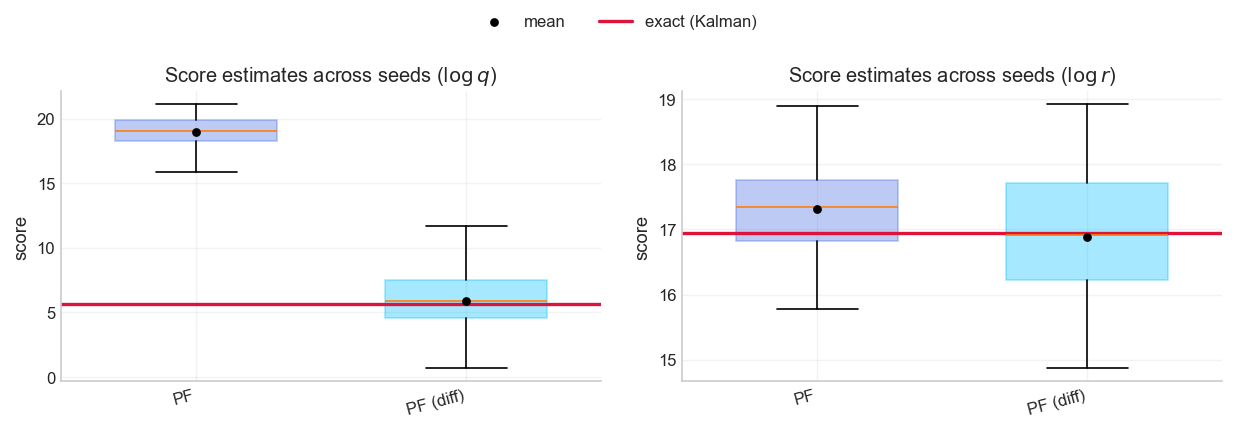

In [8]:
# --- boxplots: score distribution across seeds ---

methods_box = [
    ("PF", score_pf, "royalblue"),
    ("PF (diff)", score_pf_dpf, "deepskyblue"),
]

fig, axes = plt.subplots(1, 2, figsize=(10.5, 3.6), sharey=False)

for j, ax in enumerate(axes):
    data = [jnp.asarray(scores[:, j]) for _, scores, _ in methods_box]

    bp = ax.boxplot(
        data,
        positions=list(range(1, len(methods_box) + 1)),
        widths=0.6,
        showfliers=False,
        patch_artist=True,
    )
    for patch, (_, _, color) in zip(bp["boxes"], methods_box):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)
        patch.set_alpha(0.35)

    means = [float(jnp.mean(scores[:, j])) for _, scores, _ in methods_box]
    ax.scatter(
        list(range(1, len(methods_box) + 1)),
        means,
        color="black",
        s=18,
        zorder=3,
        label="mean",
    )
    ax.axhline(
        float(score_exact[j]), color="crimson", lw=2.0, label="exact (Kalman)"
    )

    ax.set_xticks(list(range(1, len(methods_box) + 1)))
    ax.set_xticklabels(
        [name for name, _, _ in methods_box], rotation=15, ha="right"
    )
    ax.set_title(f"Score estimates across seeds ({[r'$\log q$', r'$\log r$'][j]})")
    ax.set_ylabel("score")

handles, leg_labels = axes[0].get_legend_handles_labels()
uniq = dict(zip(leg_labels, handles))
fig.legend(uniq.values(), uniq.keys(), loc="upper center", ncol=2, frameon=False)
plt.tight_layout(rect=(0, 0, 1, 0.90))
plt.show()

In [9]:
# --- timing (100 evals, post-jit): standard vs diff-resampling ---

import time

n_timing = 1_000


def _block_until_ready(x):
    return jax.tree_util.tree_map(
        lambda y: y.block_until_ready() if hasattr(y, "block_until_ready") else y, x
    )


def _eval_pf(diff: bool):
    def _fn():
        key_local = random.PRNGKey(123)
        mll = pf_mll(
            theta_true,
            ys,
            key=key_local,
            n_particles=N_PF,
            ess_threshold=ess_threshold,
            m0=m0,
            chol_P0=chol_P0,
            differentiable_resampling=diff,
        )
        g = pf_grad(
            theta_true,
            ys,
            key=key_local,
            n_particles=N_PF,
            ess_threshold=ess_threshold,
            m0=m0,
            chol_P0=chol_P0,
            differentiable_resampling=diff,
        )
        return mll, g

    return jax.jit(_fn)


for diff, label in [(False, "PF (standard)"), (True, "PF (diff-resampling)")]:
    eval_fn = _eval_pf(diff)
    _block_until_ready(eval_fn())
    times_ms = []
    for _ in range(n_timing):
        t0 = time.perf_counter()
        _block_until_ready(eval_fn())
        times_ms.append((time.perf_counter() - t0) * 1e3)
    times_ms = jnp.array(times_ms)
    median_ms = float(jnp.median(times_ms))
    std_ms = float(jnp.std(times_ms))
    print(f"{label}: {median_ms:.2f} ± {std_ms:.2f} ms (median ± std over {n_timing} evals)")

PF (standard): 20.07 ± 2.95 ms (median ± std over 1000 evals)
PF (diff-resampling): 20.16 ± 1.47 ms (median ± std over 1000 evals)


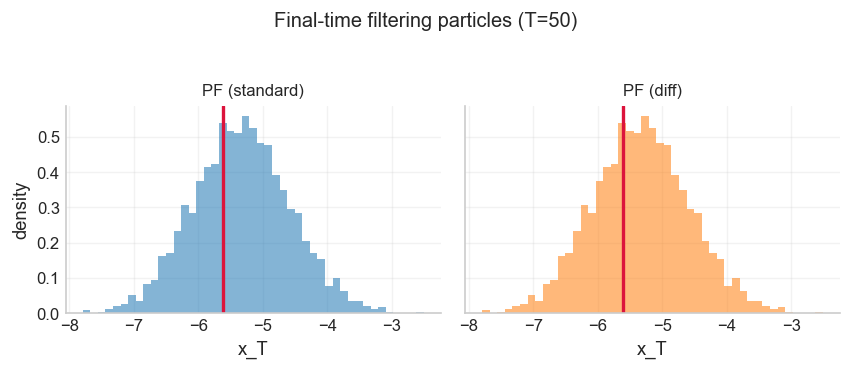

In [10]:
from matplotlib.pyplot import hist
import numpy as np


def _final_particles(diff: bool, *, key):
    log_q, log_r = theta_true
    q = jnp.exp(log_q)
    r = jnp.exp(log_r)

    H = jnp.array([[1.0]])
    d = jnp.array([0.0])
    chol_R = jnp.array([[r]])

    def init_sample(k, _mi):
        return m0 + (chol_P0 @ random.normal(k, (1,)))

    def propagate_sample(k, x_prev, _mi):
        return x_prev + q * random.normal(k, (1,))

    def log_potential(_x_prev, x, mi):
        idx = mi - 1
        return logpdf(H @ x + d, ys[idx], chol_R, nan_support=False)

    resampling_fn = (
        stop_gradient.stop_gradient_decorator(systematic.resampling)
        if diff
        else systematic.resampling
    )
    resampling_fn = adaptive.ess_decorator(resampling_fn, ess_threshold)

    filt = pf.build_filter(
        init_sample=init_sample,
        propagate_sample=propagate_sample,
        log_potential=log_potential,
        n_filter_particles=N_PF,
        resampling_fn=resampling_fn,
    )

    model_inputs = jnp.arange(ys.shape[0] + 1)
    states = run_filter(filt, model_inputs, parallel=False, key=key)
    return states.particles[-1]


hist_methods = [
    ("PF (standard)", {"diff": False, "color": "tab:blue"}),
    ("PF (diff-resampling)", {"diff": True, "color": "tab:orange"}),
]

true_xT = float(xs[-1, 0])

fig, axes = plt.subplots(
    1,
    len(hist_methods),
    figsize=(3.6 * len(hist_methods), 2.9),
    sharex=True,
    sharey=True,
)

for ax, (name, cfg) in zip(np.ravel(axes), hist_methods):
    pts = _final_particles(cfg["diff"], key=jax.random.PRNGKey(42))
    pts = np.asarray(jnp.ravel(pts))

    ax.hist(pts, bins=45, density=True, color=cfg["color"], alpha=0.55)
    ax.axvline(true_xT, color="crimson", lw=2.0)
    ax.set_title(name.replace("diff-resampling", "diff"), fontsize=10)
    ax.set_xlabel("x_T")

axes[0].set_ylabel("density")
fig.suptitle(f"Final-time filtering particles (T={ys.shape[0]})", y=1.05)
plt.tight_layout()
plt.show()